In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain
import time

sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

c:\Users\lilia\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [4]:
def get_weather(lat, lng):
    print('Getting weather...')
    start = time.time()

    weather = pvlib.iotools.get_pvgis_tmy(lat, lng,
                                        map_variables=True)[0]
    weather.index.name = "utc_time"
    
    end = time.time()
    print(f'Completed getting weather in {end-start}s')
    return weather

In [21]:
def calculate_PV(location, weather, slope, aspect):
    mount = FixedMount(surface_tilt=slope, surface_azimuth=aspect)
    array = Array(
        mount=mount,
        module_parameters=module,
        temperature_model_parameters=temperature_model_parameters,
    )
    system = PVSystem(arrays=[array], inverter_parameters=inverter)
    mc = ModelChain(system, location)
    mc.run_model(weather)
    annual_energy = mc.results.ac.sum()

    return annual_energy

In [27]:
def avg_pv_output(lat, lng, alt, weather, timezone='Etc/GMT+1'):
    print('Calculating solar output...')
    start = time.time()
    
    location = Location(
        lat,
        lng,
        name='',
        altitude=alt,
        tz=timezone,
    )

    slope_vals = np.arange(10, 61, 10)
    aspect_vals = np.arange(0, 361 , 15)

    total_energy, counter = 0, 0

    for slope in slope_vals:
        for aspect in aspect_vals:
            total_energy += calculate_PV(location, weather, slope, aspect)
            counter += 1

    avg_energy = total_energy/counter

    end = time.time()
    print(f"Completed calculating PV output of {avg_energy} in {end-start}s")
    return avg_energy

In [ ]:
def roof_segment_output(db, lat, lng, weather, timezone='Etc/GMT+1'):
    print('Calculating solar output...')
    start = time.time()

    energies = []
    
    for row in db:
        location = Location(
            lat,
            lng,
            name='',
            altitude=row['height_mean'],
            tz=timezone
        )
        annual_energy = calculate_PV(location, weather, row['slope'], row['aspect'])

        energies.append(annual_energy)

    end = time.time()
    print(f"Completed calculating PV output of {annual_energy} in {end-start}s")

    return energies

In [49]:
db.columns

Index(['gml_id', 'fid', 'featureCode', 'versionDate', 'calculatedAreaValue',
       'RelH2', 'RelHMax', 'AbsHMin', 'height_mean', 'AbsH2', 'lastUpdateDate',
       'entryDate', 'uprn', 'country', 'multiOccCount', 'buildingNumber',
       'thoroughfare', 'postTown', 'postcode', 'level', 'shading_mean',
       'geometry', 'lng', 'lat', 'pv_output'],
      dtype='object')

In [42]:
weather.index.year.unique()

Int64Index([2006, 2014, 2011, 2015, 2013, 2016, 2012, 2008, 2007], dtype='int64', name='utc_time')

In [28]:
db = gpd.read_file('../../data/output/proxy_data/SJ9000.gml', driver='GML')
db = db.to_crs(4326)
db['lng'] = db.geometry.centroid.x
db['lat'] = db.geometry.centroid.y
db.rename(columns={'AbsHMax':'height_mean'}, inplace=True)

latitude = db['lat'].mean()
longitude = db['lng'].mean()
weather = get_weather(latitude, longitude)
avg_alt = 103

pv_output = avg_pv_output(latitude, longitude, avg_alt, weather)
db['pv_output'] = db['shading_mean'] * pv_output


C:\Users\lilia\AppData\Local\Temp\ipykernel_19948\1030467422.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  db['lng'] = db.geometry.centroid.x
C:\Users\lilia\AppData\Local\Temp\ipykernel_19948\1030467422.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  db['lat'] = db.geometry.centroid.y


Getting weather...
Completed getting weather in 1.3796000480651855s
Calculating solar output...
Completed calculating PV output of 167278.84680863176 in 36.761898040771484s


In [18]:
output_db = gpd.read_file('../../data/output/solar_pv/SJ9000_results.gml', driver='GML')


Text(0.5, 0, 'PV Output (Whr/year/m²)')

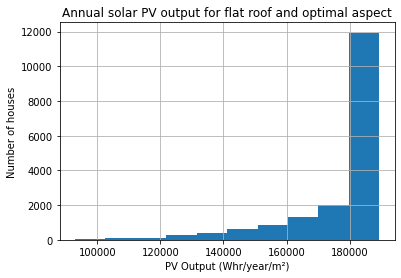

In [32]:
ax = output_db['pv_output'].hist()
ax.set_title("Annual solar PV output for flat roof and optimal aspect")
ax.set_ylabel("Number of houses")
ax.set_xlabel("PV Output (Whr/year/m\u00b2)")

Text(0.5, 0, 'PV Output (Whr/year/m²)')

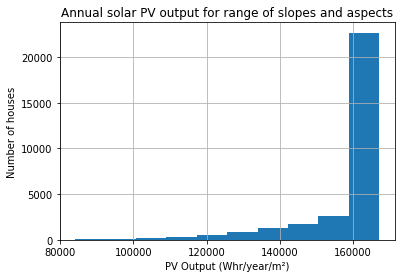

In [33]:
ax = db['pv_output'].hist()
ax.set_title("Annual solar PV output for range of slopes and aspects")
ax.set_ylabel("Number of houses")
ax.set_xlabel("PV Output (Whr/year/m\u00b2)")

In [41]:
joined_db.to_file('output_osmp/SJ9000_results.gml', driver='GML')

c:\Users\lilia\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
